In [ ]:
!pip install lmdiag

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Mount data từ Google Drive sang Colab
from google.colab import drive
drive.mount('/content/drive')

# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import lmdiag
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

Mounted at /content/drive


# 1. Đọc dữ liệu

*Lưu ý: Trong bộ dữ liệu Cancer Regression trên kaggle có 2 file .csv (cancer_reg.csv + avg-household-size.csv). Vì đề bài **yêu cầu dự đoán tỉ lệ tử vong do ung thư** nên ta chỉ dùng file **cancer_reg.csv** vì nó chứa dữ liệu liên quan và cả biến mục tiêu (trong khi file avg-household-size.csv chỉ chứa dữ liệu về địa hình và kích thước các hộ gia đình của từng vùng).*

In [ ]:
# Load Dataset
path = '/content/drive/MyDrive/NhapMonKHDL/College.csv' # Đường dẫn tới file cần đọc
df = pd.read_csv(path)  # read_excel từ đường dẫn và trả về dưới dạng một DataFrame
df.head()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


# 2. Mô tả và làm sạch dữ liệu

## Mô tả dữ liệu

Kiểm tra nhanh dữ liệu

In [ ]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(' TAIL '.center(70,'-'))
    print(dataframe.tail(head))
    print(' MISSING VALUES '.center(70,'-'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70,'-'))
    print(dataframe.duplicated().sum())

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 3047
Columns: 33
------------------------------- TYPES --------------------------------
avganncount                float64
avgdeathsperyear             int64
target_deathrate           float64
incidencerate              float64
medincome                    int64
popest2015                   int64
povertypercent             float64
studypercap                float64
binnedinc                   object
medianage                  float64
medianagemale              float64
medianagefemale            float64
geography                   object
percentmarried             float64
pctnohs18_24               float64
pcths18_24                 float64
pctsomecol18_24            float64
pctbachdeg18_24            float64
pcths25_over               float64
pctbachdeg25_over          float64
pctemployed16_over         float64
pctunemployed16_over       float64
pctprivatecoverage         float64
pctprivatecoveragealone    flo

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Giới hạn (Threshold) cho số giá trị duy nhất (unique value) để được coi là 1 biến categorical (cat) hoặc high-carndinality categorical (car)
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'Categorical Columns: {len(cat_cols)}')
    print(f'Numerical Columns: {len(num_cols)}')
    print(f'Categorical but cardinal: {len(cat_but_car)}')
    print(f'Numerical but categorical: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=10)
print(cat_cols, num_cols, cat_but_car, sep='\n')

Observations: 3047
Variables: 33
Categorical Columns: 1
Numerical Columns: 31
Categorical but cardinal: 1
Numerical but categorical: 0
['binnedinc']
['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate', 'medincome', 'popest2015', 'povertypercent', 'studypercap', 'medianage', 'medianagemale', 'medianagefemale', 'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctsomecol18_24', 'pctbachdeg18_24', 'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over', 'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone', 'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone', 'pctwhite', 'pctblack', 'pctasian', 'pctotherrace', 'pctmarriedhouseholds', 'birthrate']
['geography']


In [ ]:
print(f"'binnedinc' Unique Values: {df['binnedinc'].nunique()}")
print(f"'geography' Unique Values: {df['geography'].nunique()}")

'binnedinc' Unique Values: 10
'geography' Unique Values: 3047


**Nhận xét nhanh:**
*   Có 3 biến bị khuyết dữ liệu là: 'pctsomecol18_24', 'pctemployed16_over' và 'pctprivatecoveragealone'.
*   Biến 'pctsomecol18_24' và 'pctprivatecoveragealone' lần lượt bị khuyết khoảng 20% và 75%. Các biến này không nên điền khuyết (Fill) vì khuyết quá nhiều.
*   Biến 'pctemployed16_over' bị khuyết khoảng 5%. Ta có thể điền khuyết để xử lý biến này vì phần khuyết nhỏ.
*   Biến 'binnedinc' là categorical có 10 giá trị duy nhất, biến 'geography' là biến có rất nhiều giá trị duy nhất.



## Loại bỏ các biến không sử dụng

Loại bỏ 2 biến 'pctsomecol18_24', 'pctprivatecoveragealone' vì bị khuyết quá nhiều.

In [ ]:
df.drop(['pctsomecol18_24', 'pctprivatecoveragealone'], axis = 1, inplace = True)

Biến 'binnedinc' chia trung bình thu nhập của các vùng thành 10 phần (Khoảng cách mỗi phần không bằng nhau) trong khi bộ dữ liệu đã có cột trung bình thu nhập. Vậy biến này là tổ hợp tuyến tính của biến trung bình thu nhập và không cung cấp thêm thông tin nên ta loại bỏ.

In [ ]:
df['binnedinc']

0        (61494.5, 125635]
1       (48021.6, 51046.4]
2       (48021.6, 51046.4]
3         (42724.4, 45201]
4       (48021.6, 51046.4]
               ...        
3042      (45201, 48021.6]
3043    (48021.6, 51046.4]
3044    (51046.4, 54545.6]
3045    (48021.6, 51046.4]
3046    (40362.7, 42724.4]
Name: binnedinc, Length: 3047, dtype: object

In [ ]:
df.drop(['binnedinc'], axis = 1, inplace = True)

## Nhóm biến High-cardinality

Biến 'geography' gồm tên các hạt/quận (county) và tiểu bang tương ứng. Ta sẽ tách biến 'geography' thành biến 'county' và 'state' lần lượt chứa tên các hạt/quận và tiếu bang. Sau đó, ta gom nhóm các bang thành 4 vùng lớn theo cách chia dưới đây:

Region 1: Northeast

*   Division 1: New England (Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, and Vermont)

*   Division 2: Middle Atlantic (New Jersey, New York, and Pennsylvania)

Region 2: Midwest

*   Division 3: East North Central (Illinois, Indiana, Michigan, Ohio, and Wisconsin)

*   Division 4: West North Central (Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota, and South Dakota)

Region 3: South

*   Division 5: South Atlantic (Delaware, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, District of Columbia, and West Virginia)

*   Division 6: East South Central (Alabama, Kentucky, Mississippi, and Tennessee)

*   Division 7: West South Central (Arkansas, Louisiana, Oklahoma, and Texas)

Region 4: West

*   Division 8: Mountain (Arizona, Colorado, Idaho, Montana, Nevada, New Mexico,
Utah, and Wyoming)

*   Division 9: Pacific (Alaska, California, Hawaii, Oregon, and Washington)

In [ ]:
df['geography'].head(10)

0          Kitsap County, Washington
1        Kittitas County, Washington
2       Klickitat County, Washington
3           Lewis County, Washington
4         Lincoln County, Washington
5           Mason County, Washington
6        Okanogan County, Washington
7         Pacific County, Washington
8    Pend Oreille County, Washington
9          Pierce County, Washington
Name: geography, dtype: object

In [ ]:
df[['county', 'state']] = df['geography'].str.split(', ', n=1, expand=True)

In [ ]:
df.drop(['geography', 'county'], axis = 1, inplace = True)

In [ ]:
region_1 = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania']
region_2 = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota']
region_3 = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
region_4 = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']

df['state'] = df['state'].apply(lambda x: 1 if x in region_1 else 2 if x in region_2 else 3 if x in region_3 else 4 if x in region_4 else 0)

In [ ]:
df['state'].value_counts()

state
3    1383
2    1029
4     418
1     217
Name: count, dtype: int64

### Đổi tên biến

Vì tên biến 'state' không đúng với ý nghĩa từng vùng sau khi nhóm nên ta đổi thành 'region'. Ngoài ra, ta đổi tên biến mục tiêu cho ngắn gọn hơn.

In [ ]:
df = df.rename(columns={'state': 'region',
                        'target_deathrate': 'deathrate'
                        })

## Chuyển đổi biến

Biến 'state' không có đơn vị tính, dù ta đã mã hóa các bang thành những vùng 1, 2, 3, 4 nhưng các con số này chỉ là con số đại diện, ta không thể thực hiện cộng trừ nhân chia với nó để xem nhóm này hơn nhóm kia bao nhiêu đơn vị.

=> Biến 'state' không thể phân tích hồi quy, ta cần chuyển các biến định tính không có thước đo đơn vị này về một dạng biến khác có thước đo đơn vị để có thể lượng hóa, đó là biến giả (Dummy).

In [ ]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns = categorical_cols,
                               drop_first = drop_first)
    return dataframe

In [ ]:
df = one_hot_encoder(df, ['region'])
df.head()

,avganncount,avgdeathsperyear,deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,region_1,region_2,region_3,region_4
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,39.3,36.9,...,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831,False,False,False,True
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,33.0,32.2,...,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096,False,False,False,True
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,45.0,44.0,...,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488,False,False,False,True
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,42.8,42.2,...,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841,False,False,False,True
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,48.3,47.8,...,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657,False,False,False,True


## Xử lý giá trị khuyết

In [ ]:
df[df['pctemployed16_over'].isna()]['pctemployed16_over']

11     NaN
46     NaN
104    NaN
105    NaN
168    NaN
        ..
2986   NaN
2997   NaN
3007   NaN
3038   NaN
3045   NaN
Name: pctemployed16_over, Length: 152, dtype: float64

Ta điền các giá trị khuyết bằng hàm sinh các mẫu ngẫu nhiên có Phân phối Chuẩn với Trung bình và Độ lệch chuẩn được tính bằng các giá trị không bị khuyết của biến 'pctemployed16_over'.

In [ ]:
NA = df[df['pctemployed16_over'].isna()]
# Hàm mean() và std() chỉ tính toán với các giá trị không phải NaN nên phù hợp để dùng cho điền khuyết
mean = df['pctemployed16_over'].mean()
std = df['pctemployed16_over'].std()

filler = pd.Series(np.random.normal(loc=mean, scale=std, size=NA.shape[0]), index=NA.index) # Phải có index=NA.index để các giá trị điền khuyết được đúng vị trí index trong df
df['pctemployed16_over'] = df['pctemployed16_over'].fillna(filler)

In [ ]:
df['pctemployed16_over'].loc[NA.index]

11      45.737933
46      65.479794
104     68.355814
105     64.488415
168     64.613069
          ...    
2986    65.399001
2997    35.764822
3007    66.300280
3038    55.643844
3045    62.970575
Name: pctemployed16_over, Length: 152, dtype: float64

In [ ]:
df.isnull().sum()

avganncount               0
avgdeathsperyear          0
deathrate                 0
incidencerate             0
medincome                 0
popest2015                0
povertypercent            0
studypercap               0
medianage                 0
medianagemale             0
medianagefemale           0
percentmarried            0
pctnohs18_24              0
pcths18_24                0
pctbachdeg18_24           0
pcths25_over              0
pctbachdeg25_over         0
pctemployed16_over        0
pctunemployed16_over      0
pctprivatecoverage        0
pctempprivcoverage        0
pctpubliccoverage         0
pctpubliccoveragealone    0
pctwhite                  0
pctblack                  0
pctasian                  0
pctotherrace              0
pctmarriedhouseholds      0
birthrate                 0
region_1                  0
region_2                  0
region_3                  0
region_4                  0
dtype: int64

# Tiền xử lý dữ liệu

Đối với mô hình Linear Regression cơ bản, chuẩn hóa chỉ thay đổi khoảng giá trị của các trọng số nên các metrics đánh giá cuối cùng của mô hình không thay đổi.
=> Trong bài này em sẽ không chuẩn hóa.

Phần này sẽ bao gồm:
1. Chia bộ dữ liệu thành tập các biến dự đoán hay đặc trưng (X) và biến phụ thuộc hay mục tiêu (Y)

In [ ]:
def prepare_X_y(df):
    # Split data into X and y. Return two dataframes
    columns = df.columns.tolist()
    columns.remove('deathrate')
    X = df[columns] # Select features
    y = df['deathrate'] # Select label
    return X, y

X, y = prepare_X_y(df)
print(X.shape)
print(y.shape)

(3047, 32)
(3047,)


In [ ]:
X_std = (X - X.mean(axis = 0))/X.std(axis = 0, ddof = 1)
y_std = (y - y.mean(axis = 0))/y.std(axis = 0, ddof = 1)

# PCA

In [ ]:
# Sử dụng PCA mà chưa bỏ đi thành phần chính nào để xem lượng thông tin mỗi thành phần giữ lại được
pca = PCA(random_state=0)
pca.fit(X_std)
eigenvals = pca.explained_variance_
eigenvecs = pca.components_

In [ ]:
cumsum = np.cumsum(eigenvals)
cumsum /= cumsum[-1]
cumsum

array([0.26793523, 0.42615972, 0.50209753, 0.56848657, 0.61738699,
       0.66360822, 0.70118527, 0.73266157, 0.7639834 , 0.79236068,
       0.82001552, 0.84508779, 0.86842405, 0.88880178, 0.9078763 ,
       0.92315427, 0.93731875, 0.95032267, 0.96130649, 0.97012526,
       0.97692146, 0.98181771, 0.98588662, 0.98903742, 0.99146311,
       0.99360848, 0.99553522, 0.99729916, 0.99887023, 0.99943912,
       1.        , 1.        ])

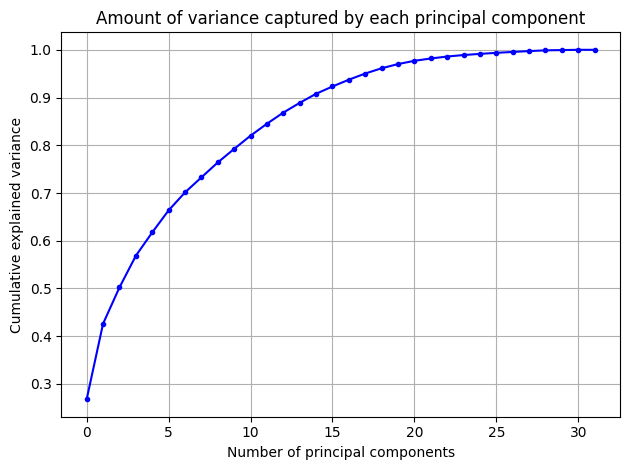

In [ ]:
plt.plot(range(len(cumsum)), cumsum, marker='.', linestyle='-', color='b')
plt.title('Amount of variance captured by each principal component')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def find_num_pc(eigenvals, threshold = 0.9):
    cumsum = np.cumsum(eigenvals)
    cumsum /= cumsum[-1]
    for i, val in enumerate(cumsum):
        if val >= threshold:
            return i + 1

In [ ]:
num_pc = find_num_pc(eigenvals, threshold = 0.9)
num_pc

15

In [ ]:
# Với kết quả ở trên, sử dụng 15 thành phần chính có thể giữ lại được ít nhất 90% thông tin ban đầu
X_pca = PCA(n_components=num_pc, random_state=0).fit_transform(X_std.copy())
X_pca = pd.DataFrame(X_pca)
X_pca.columns =['pc'+str(i + 1) for i in range(X_pca.shape[1])]
X_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15
0,2.403527,1.538430,0.570626,1.321829,-1.044055,-1.041138,1.104662,0.736600,1.919221,-0.219899,-1.271630,-0.048034,0.702168,0.226867,-0.016597
1,1.623536,2.272806,-1.680893,1.290165,-0.519080,-2.580619,1.184442,-0.736686,0.229824,1.424119,-1.013254,0.206103,-0.156879,-0.459804,-0.901831
2,-0.029490,-0.912911,1.060113,2.314280,-1.791014,-2.136748,-0.211314,-0.593458,0.162747,0.296429,-0.321494,-0.671299,-0.231767,-0.656398,-0.304381
3,-1.645832,-0.550928,1.306676,1.734918,-0.570507,-1.483161,1.327491,0.010241,1.172091,0.403238,-0.860586,-0.650187,0.418620,-0.423886,-0.090510
4,-0.177089,-2.203766,1.536986,2.408157,-1.475128,-1.474324,0.110118,0.291907,0.832713,-0.375665,-1.176005,0.415905,-0.775784,-0.768194,-0.686438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1.956266,-0.970025,0.359178,-0.341871,1.077146,-0.685566,-1.366691,0.257995,-0.614722,-0.608400,-0.206856,0.317108,0.349338,0.211407,-0.490306
3043,1.855215,1.978040,-1.846069,2.615148,2.687446,0.464150,0.574295,0.343904,-0.853512,-0.527373,1.580734,-0.616976,-0.176196,2.207456,0.074000
3044,2.028199,0.850459,-1.569012,1.472379,2.927213,0.503514,1.052718,0.736655,2.383291,-0.213477,2.111276,-0.263921,-0.174909,0.229524,0.012229
3045,2.609164,-1.072192,-0.423849,0.221913,1.639562,0.890350,0.274050,0.339897,-0.054614,0.058864,-0.672645,0.318830,-0.209501,0.167053,-0.216553


# So sánh kết quả của mô hình Machine Learning khi sử dụng 2 bộ dữ liệu


## Chia tập Train-test

In [ ]:
TRAIN_SIZE = 0.8 # Chọn tỉ lệ tập Train

# Dùng hàm train_test_split để chia X(gốc và PCA) và y thành 2 tập: train và test
# Với train_size là tỉ lệ của tập train và cố định random_state để không bị thay đổi kết quả
# Ta chỉnh shuffle=True để xáo bộ dữ liệu trước khi chia vì bộ dữ liệu này được thu thập theo từng bang, từng vùng => Nếu không shuffle thì có thể có vùng trong tập test mà tập train không có
X_std_train, X_std_test, X_pca_train, X_pca_test, y_std_train, y_std_test = train_test_split(X_std, X_pca,  y_std, train_size=TRAIN_SIZE, shuffle=True, random_state=0)
print(f"Training set size: \tX_std_train: {X_std_train.shape} \tX_pca_train: {X_pca_train.shape} \ty_std_train: {y_std_train.shape}")
print(f"Testing set size: \tX_std_test: {X_std_test.shape} \t\tX_pca_test: {X_pca_test.shape} \t\ty_std_test: {y_std_test.shape}")

Training set size: 	X_std_train: (2437, 32) 	X_pca_train: (2437, 15) 	y_std_train: (2437,)
Testing set size: 	X_std_test: (610, 32) 		X_pca_test: (610, 15) 		y_std_test: (610,)


## Khởi tạo mô hình Linear Regression

In [ ]:
def build_linear_model(X, y):
    # X, y nên lấy từ tập Train
    # Tách tên của các biến X, y để viết hàm hồi quy
    X_variable = list(X.columns.values)
    y_variable = y.name
    data = pd.concat([X, y], axis=1, join='inner')
    formula = y_variable + '~' +'+'.join(X_variable)
    # Dùng hàm Ordinary Least Squares regression (OLS) từ sklearn, input là hàm hồi quy (có bias) và dữ liệu của các biến (X, y)
    model = smf.ols(formula=formula, data=data)
    # Fit/Train model
    results = model.fit()
    return results

# Huấn luyện mô hình với tập Train
model_pca = build_linear_model(X_pca_train, y_std_train)
model_std = build_linear_model(X_std_train, y_std_train)

## Mô hình sử dụng bộ dữ liệu được PCA

In [ ]:
model_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              deathrate   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     169.0
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        13:05:23   Log-Likelihood:                -2576.5
No. Observations:                2437   AIC:                             5185.
Df Residuals:                    2421   BIC:                             5278.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0017      0.014     -0.123      0.902      -0.030       0.026
pc1           -0.1708      0.005    -35.273      0.000      -0.180      -0.161
pc2           -0.0156      0.006     -2.434      0.015      -0.028      -0.003
pc3           -0.0121      0.010     -1.243      0.214      -0.031       0.007
pc4           -0.2405      0.010    -24.676      0.000      -0.260      -0.221
pc5            0.0837      0.012      7.280      0.000       0.061       0.106
pc6            0.1761      0.012     14.667      0.000       0.153       0.200
pc7            0.1448      0.013     11.133      0.000       0.119       0.170
pc8            0.0149      0.014      1.061      0.289      -0.013       0.042
pc9            0.0818      0.014      5.869      0.000       0.054       0.109
pc10           0.0593      0.015      4.011      0.000       0.030       0.088
pc11          -0.0709      0.015     -4.762      0.000      -0.100      -0.042
pc12          -0.0080      0.016     -0.511      0.609      -0.039       0.023
pc13           0.1512      0.017      9.148      0.000       0.119       0.184
pc14           0.1906      0.018     10.550      0.000       0.155       0.226
pc15           0.0896      0.018      4.883      0.000       0.054       0.126
==============================================================================
Omnibus:                      205.856   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1043.361
Skew:                           0.220   Prob(JB):                    2.74e-227
Kurtosis:                       6.175   Cond. No.                         3.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_pca_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_pca_train.values, i) for i in range(len(X_pca_train.columns))]
print(vif_data)

   feature       VIF
0      pc1  1.000397
1      pc2  1.011730
2      pc3  1.026544
3      pc4  1.002897
4      pc5  1.007226
5      pc6  1.012006
6      pc7  1.001901
7      pc8  1.001565
8      pc9  1.001560
9     pc10  1.003868
10    pc11  1.002775
11    pc12  1.000350
12    pc13  1.001394
13    pc14  1.004403
14    pc15  1.006928


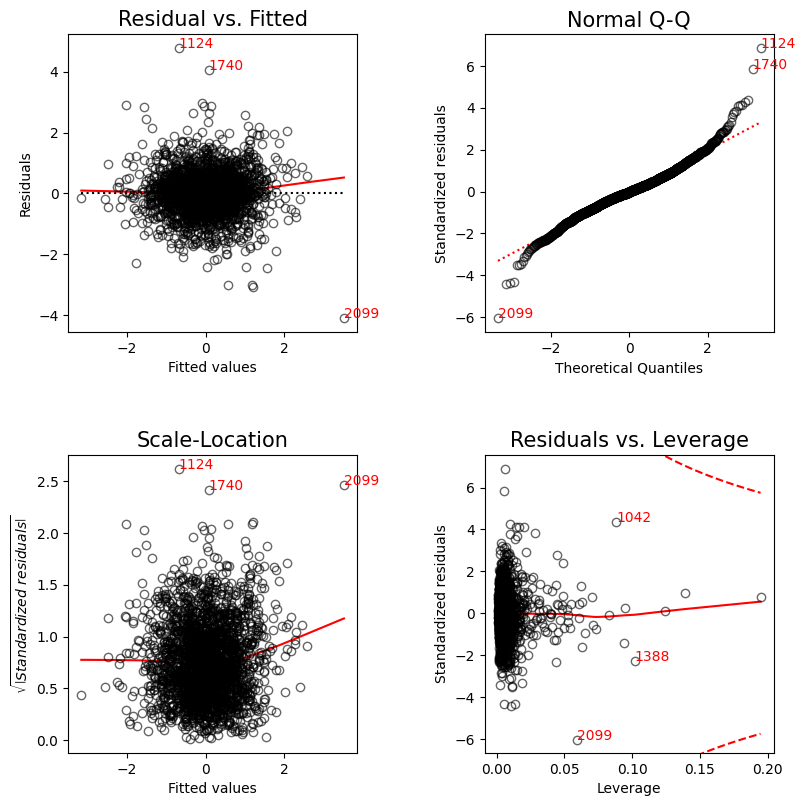

In [ ]:
plt.figure(figsize=(8, 8))
lmdiag.plot(model_pca);

In [ ]:
y_pred_train = model_pca.predict(X_pca_train)
print("Train MSE: ", mean_squared_error(y_pred_train, y_std_train))
y_pred_test = model_pca.predict(X_pca_test)
print("Test MSE: ", mean_squared_error(y_pred_test, y_std_test))

Train MSE:  0.48509076068622703
Test MSE:  0.43873119495083973


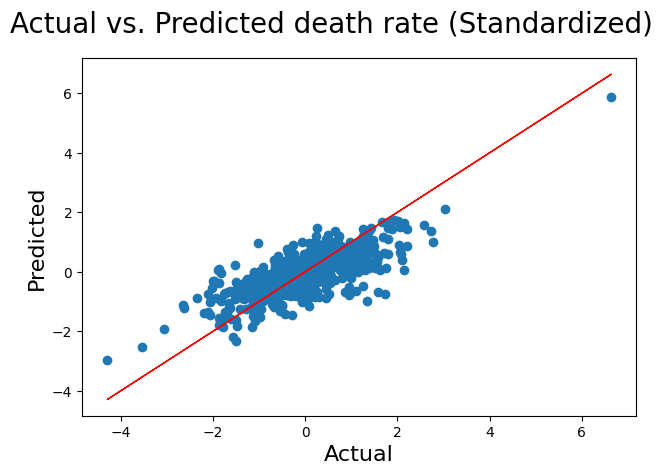

In [ ]:
plt.figure()
plt.scatter(y_std_test, y_pred_test)
plt.plot(y_std_test, y_std_test, label='line', color='red', linewidth=1)
plt.suptitle('Actual vs. Predicted death rate (Standardized)', fontsize=20)
plt.xlabel('Actual', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.tight_layout()
plt.show()

**Nhận xét:**
*   Mô hình giải thích được khoảng 50,8% lượng thông tin của biến tỉ lệ tử vong do ung thư 'deathrate'.
*   Điểm VIF của các biến dự đoán đều nhỏ hơn 5 và điểm Condition number thấp cho thấy các biến dự đoán độc lập tuyến tính với nhau.
*   Điểm p-value của các biến 'pc2', 'pc3', 'pc8' và 'pc12' lớn nghĩa là trong mô hình hiện tại, các biến này không có ý nghĩa thống kê.
*   Trên biểu đồ "Residual vs. Fitted" và "Scale-Location" ta thấy đường màu đỏ bị cong lên trên bên phải. Điều này cho thấy phương sai của Residual (phần dư) không phải là một hằng số và có thể tồn tại tương quan phi tuyến giữa biến mục tiêu 'deathrate' và các biến dự đoán.
*   Trên biểu đồ "Normal Q-Q" ta thấy hầu hết các điểm đều nằm dọc trên 1 đường chéo. Điều này cho thấy các Residuals có phân phối chuẩn (Giả định phân phối chuẩn của phần dư (Residuals) không bị vi phạm).
*   Điểm MSE khá thấp chứng tỏ mô hình có khả năng dự đoán tỉ lệ tử vong 'deathrate' tốt.

## Model thường

In [ ]:
model_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              deathrate   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     91.08
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        13:05:28   Log-Likelihood:                -2503.1
No. Observations:                2437   AIC:                             5070.
Df Residuals:                    2405   BIC:                             5256.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0021      0.014     -0.152      0.879      -0.029       0.025
avganncount               -0.1600      0.044     -3.627      0.000      -0.246      -0.073
avgdeathsperyear           0.3395      0.078      4.349      0.000       0.186       0.493
incidencerate              0.3619      0.016     22.031      0.000       0.330       0.394
medincome                  0.0990      0.038      2.575      0.010       0.024       0.174
popest2015                -0.2179      0.074     -2.931      0.003      -0.364      -0.072
povertypercent             0.0745      0.040      1.869      0.062      -0.004       0.153
studypercap               -0.0014      0.014     -0.100      0.920      -0.028       0.026
medianage                 -0.0055      0.014     -0.395      0.693      -0.033       0.022
medianagemale             -0.0576      0.042     -1.356      0.175      -0.141       0.026
medianagefemale           -0.0369      0.045     -0.823      0.410      -0.125       0.051
percentmarried             0.2223      0.045      4.976      0.000       0.135       0.310
pctnohs18_24              -0.0131      0.018     -0.717      0.473      -0.049       0.023
pcths18_24                 0.0673      0.018      3.795      0.000       0.033       0.102
pctbachdeg18_24           -0.0350      0.020     -1.778      0.075      -0.074       0.004
pcths25_over               0.1153      0.028      4.089      0.000       0.060       0.171
pctbachdeg25_over         -0.1760      0.034     -5.213      0.000      -0.242      -0.110
pctemployed16_over        -0.0926      0.030     -3.124      0.002      -0.151      -0.034
pctunemployed16_over       0.0633      0.023      2.788      0.005       0.019       0.108
pctprivatecoverage        -0.1072      0.058     -1.858      0.063      -0.220       0.006
pctempprivcoverage         0.0827      0.039      2.137      0.033       0.007       0.159
pctpubliccoverage         -0.0141      0.069     -0.203      0.839      -0.150       0.122
pctpubliccoveragealone     0.0900      0.067      1.346      0.178      -0.041       0.221
pctwhite                  -0.0878      0.038     -2.317      0.021      -0.162      -0.013
pctblack                  -0.1543      0.034     -4.504      0.000      -0.221      -0.087
pctasian                   0.0195      0.019      1.011      0.312      -0.018       0.057
pctotherrace              -0.0982      0.017     -5.613      0.000      -0.132      -0.064
pctmarriedhouseholds      -0.2992      0.040     -7.570      0.000      -0.377      -0.222
birthrate                 -0.0432      0.015     -2.870      0.004      -0.073      -0.014
region_1                  -0.0767      0.015     -5.263      0.000      -0.105      -0.048
region_2                   0.0085      0.012      0.680      0.497      -0.016  

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_std_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_std_train.values, i) for i in range(len(X_std_train.columns))]
print(vif_data)

                   feature        VIF
0              avganncount   8.493935
1         avgdeathsperyear  26.465257
2            incidencerate   1.342484
3                medincome   7.687433
4               popest2015  22.378119
5           povertypercent   8.433739
6              studypercap   1.057487
7                medianage   1.026564
8            medianagemale   9.646019
9          medianagefemale  10.634750
10          percentmarried  10.579714
11            pctnohs18_24   1.745994
12              pcths18_24   1.641096
13         pctbachdeg18_24   2.039632
14            pcths25_over   4.194545
15       pctbachdeg25_over   5.937593
16      pctemployed16_over   4.616018
17    pctunemployed16_over   2.694872
18      pctprivatecoverage  17.323916
19      pctempprivcoverage   7.903433
20       pctpubliccoverage  25.285508
21  pctpubliccoveragealone  23.431332
22                pctwhite   7.615018
23                pctblack   6.269569
24                pctasian   2.020748
25          

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


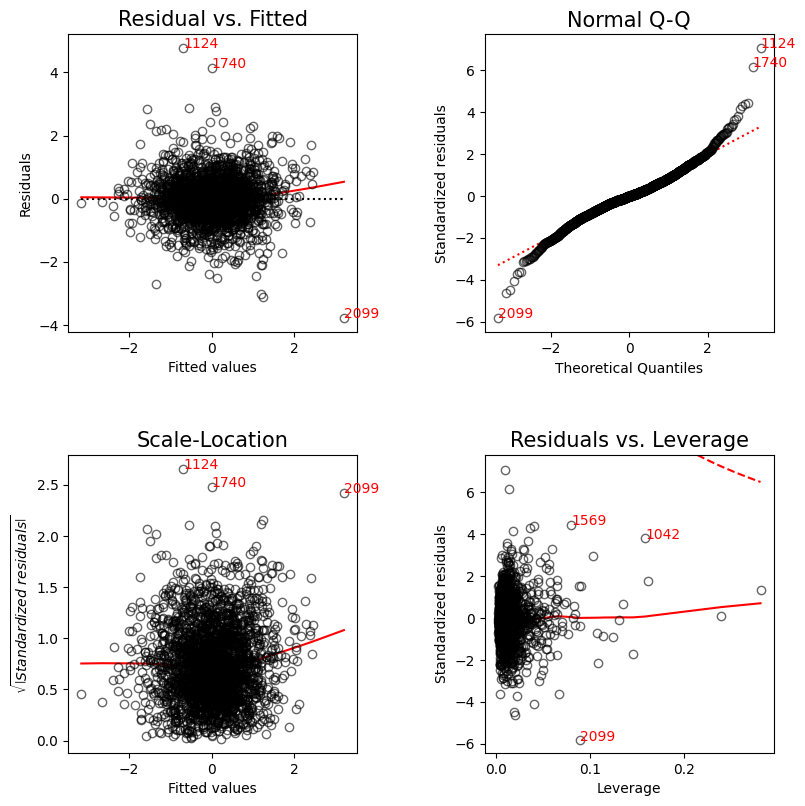

In [ ]:
plt.figure(figsize=(8, 8))
lmdiag.plot(model_std);

In [ ]:
y_pred_train = model_std.predict(X_std_train)
print("Train MSE: ", mean_squared_error(y_pred_train, y_std_train))
y_pred_test = model_std.predict(X_std_test)
print("Test MSE: ", mean_squared_error(y_pred_test, y_std_test))

Train MSE:  0.45674446900047244
Test MSE:  0.42975849529165144


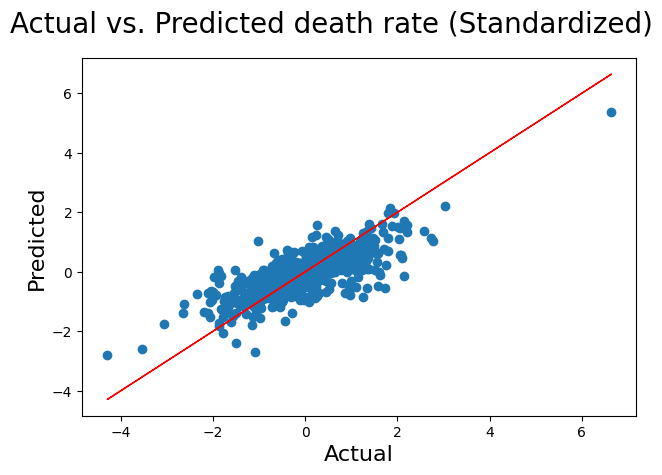

In [ ]:
plt.figure()
plt.scatter(y_std_test, y_pred_test)
plt.plot(y_std_test, y_std_test, label='line', color='red', linewidth=1)
plt.suptitle('Actual vs. Predicted death rate (Standardized)', fontsize=20)
plt.xlabel('Actual', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.tight_layout()
plt.show()

**Nhận xét:**
*   Mô hình giải thích được khoảng 53,5% lượng thông tin của biến tỉ lệ tử vong do ung thư 'deathrate'.
*   Hơn một nửa các biến dự đoán có điểm VIF lớn hơn 5 cho thấy đã xảy ra đa cộng tuyến (hiện tượng phụ thuộc tuyến tính) giữa các biến dự đoán (X). Điều này vi phạm giả định các biến dự đoán phải độc lập tuyến tính với nhau.
*   Điểm p-value của các biến 'povertypercent', 'studypercap', 'medianage', 'medianagemale', 'medianagefemale', 'pctnohs18_24', 'pctbachdeg18_24', 'pctunemployed16_over', 'pctprivatecoverage', 'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone', 'pctwhite', 'pctasian' và 'region_2' lớn nghĩa là trong mô hình hiện tại, các biến này không có ý nghĩa thống kê.
*   Trên biểu đồ "Residual vs. Fitted" và "Scale-Location" ta thấy đường màu đỏ bị cong lên trên bên phải. Điều này cho thấy phương sai của Residual (phần dư) không phải là một hằng số và có thể tồn tại tương quan phi tuyến giữa biến mục tiêu 'deathrate' và các biến dự đoán.
*   Trên biểu đồ "Normal Q-Q" ta thấy hầu hết các điểm đều nằm dọc trên 1 đường chéo. Điều này cho thấy các Residuals có phân phối chuẩn (Giả định phân phối chuẩn của phần dư (Residuals) không bị vi phạm).
*   Điểm MSE khá thấp chứng tỏ mô hình có khả năng dự đoán tỉ lệ tử vong 'deathrate' tốt.

## So sánh hiệu quả của 2 mô hình

*   Sau khi giảm chiều dữ liệu bằng PCA (từ 32 chiều xuống 15 chiều), độ phức tạp của mô hình đã giảm hơn một nửa. Tuy nhiên, giảm chiều cũng làm mất mát thông tin khiến khả năng lưu trữ, giải thích được thông tin biến mục tiêu 'deathrate' giảm từ 53.4% xuống 50.8%.

  => Tùy vào mục đích ta có thể cân nhắc giữa độ phức tạp của mô hình và lượng thông tin giữ lại được để cho ra kết quả tốt nhất.

*   Mô hình sử dụng bộ dữ liệu đã PCA đảm bảo được giả định độc lập tuyến tính giữa các biến dự đoán, trong khi bộ dữ liệu ban đầu bị đa cộng tuyến rất nặng (nếu xử lý tận gốc có thể sẽ rất mất thời gian và phức tạp).

  => PCA trước khi huấn luyện các mô hình tuyến tính có thể giảm bớt gánh nặng khi kiểm tra các giả định của mô hình.

*   Cả 2 mô hình đều cho thấy khả năng giải thích được thông tin của biến mục tiêu 'deathrate' là không quá tốt, chỉ ở mức chấp nhận được. Ngoài ra, các biểu đồ phân tích còn cho thấy dấu hiệu của tương quan phi tuyến giữa biến mục tiêu và các biến dự đoán.

  => Mô hình Linear Regression ở đây không phải là một mô hình tốt cho bộ dữ liệu này. Tuy nhiên, mục đích chính của ta vẫn là tìm hiểu tác động của dữ liệu được PCA và không PCA lên mô hình. Ở đây, mô hình Linear Regression vẫn có thể cho ta thấy được sự khác biệt.



## Tìm hiểu cấu trúc dữ liệu thông qua tương quan với các thành phần chính

In [ ]:
def pairwise_correlation(df_a, df_b):
    correlation = {}
    correlations = pd.DataFrame()
    for col_a in df_a.columns:
        for col_b in df_b.columns:
            correlation[col_b] = df_a[col_a].corr(df_b[col_b])
        correlations[col_a] = correlation
    return correlations

def highlight_values(df, threshold):
    def highlight(value):
        if value > threshold: # Các giá trị dương lớn hơn threshold sẽ được tô xanh dương => Tương quan thuận
            return 'background-color: blue'
        elif abs(value) > threshold and value < 0: # Các giá trị âm có trị tuyệt đối lớn hơn threshold sẽ được tô đỏ => Tương quan nghịch
            return 'background-color: red'
        else:
            return ''

    return df.style.applymap(highlight)

In [ ]:
corr = pairwise_correlation(X_pca, X_std)
highlight_values(corr, threshold=0.5)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15
avganncount,0.286968,0.604284,0.627018,0.031360,0.207079,0.220611,-0.081162,-0.014155,0.003770,0.040931,-0.018847,0.027962,0.042077,-0.042222,-0.077439
avgdeathsperyear,0.212376,0.656961,0.633151,0.028085,0.146439,0.245178,-0.049247,-0.030976,0.008513,0.061181,-0.025521,0.027032,0.023353,-0.085054,-0.077382
incidencerate,-0.007998,0.064853,0.054168,-0.590315,0.078160,0.122567,0.344226,0.114828,0.128625,-0.021642,-0.082599,0.019291,0.525308,0.421859,-0.049937
medincome,0.850107,0.154019,-0.044689,0.064107,-0.210771,0.095886,0.030418,0.109390,0.015780,-0.167655,-0.030146,-0.126280,0.057879,0.007042,0.114015
popest2015,0.223197,0.660729,0.605536,0.085900,0.150257,0.262198,-0.060491,-0.030203,0.016259,0.078849,-0.033809,0.021182,0.016036,-0.081090,-0.060760
povertypercent,-0.878879,0.259164,-0.079408,-0.022115,0.116511,-0.091056,-0.002386,-0.072895,-0.019887,0.105929,-0.003458,0.082389,-0.014329,-0.027350,0.047503
studypercap,0.104229,0.074792,0.030279,-0.117923,0.246309,-0.194062,0.037675,0.095097,0.709829,-0.068245,0.575371,-0.055002,-0.029165,-0.109946,0.030899
medianage,-0.016583,-0.092799,0.118079,-0.052946,-0.152156,-0.050678,-0.051249,0.799421,-0.207712,0.478971,0.174209,0.001816,-0.009186,-0.034780,0.029839
medianagemale,-0.031141,-0.624327,0.567830,-0.136193,-0.303643,-0.165467,-0.244081,0.027493,0.056936,-0.147615,-0.018381,-0.014869,-0.017616,0.093838,-0.045629
medianagefemale,-0.101998,-0.601540,0.565139,-0.182651,-0.280649,-0.152291,-0.284182,0.032667,0.042146,-0.179787,0.004061,-0.023488,-0.026356,0.072057,-0.054638


**Nhận xét nhanh:**
*  Thành phần chính đầu tiên 'pc1' có mối tương quan mạnh mẽ với 12 biến gốc. Trong đó:

  -> 'pc1' có tương quan thuận với thu nhập trung bình, tỉ lệ kết hôn, tỉ lệ hộ gia đình đã kết hôn, tỉ lệ có việc làm từ 16 tuổi trở lên, tỉ lệ chỉ có bảo hiểm y tế tư nhân, tỉ lệ có bảo hiểm y tế tư nhân được công ty hỗ trợ, 'pctbachdeg18_24', 'pctbachdeg25_over' (Không có giải thích về 2 biến nên chỉ ghi tên biến). Điều này cho thấy 8 tiêu chí này biến thiên cùng nhau và cùng với 'pc1'.

  -> 'pc1' có tương quan nghịch với tỉ lệ nghèo đói, tỉ lệ thất nghiệp từ 16 tuổi trở lên, tỉ lệ có bảo hiểm y tế xã hội, tỉ lệ chỉ có bảo hiểm y tế xã hội. Điều này cho thấy 4 tiêu chí này biến thiên cùng nhau và ngược với 'pc1'.
  
  Thành phần này có thể được coi là một chỉ số của độ lớn về thu nhập trung bình, tỉ lệ kết hôn, tỉ lệ có việc làm, tỉ lệ có bảo hiểm y tế tư nhân và độ nhỏ về tỉ lệ nghèo đói, tỉ lệ thất nghiệp, tỉ lệ có bảo hiểm y tế xã hội. Các khu vực có giá trị thành phần chính này càng lớn thì thu nhập của những khu vực đó càng cao, kết hôn càng nhiều, tỉ lệ có việc làm và có bảo hiểm y tế tư nhân càng lớn. Đồng thời, tỉ lệ nghèo đói, thất nghiệp và có bảo hiểm y tế xã hội của khu vực đó càng thấp.

*  Thành phần chính 'pc2' có mối tương quan mạnh mẽ với 10 biến gốc. Trong đó:

  -> 'pc2' có tương quan thuận với trung bình số ca phát hiện ung thư mỗi năm, trung bình số ca tử vong do ung thư mỗi năm, ước tính dân số (2015), tỉ lệ là người Châu Á. Điều này cho thấy 4 tiêu chí này biến thiên cùng nhau và cùng với 'pc2'.

  -> 'pc2' có tương quan nghịch với tuổi thọ trung bình nam giới và nữ giới, tỉ lệ kết hôn, tỉ lệ hộ gia đình đã kết hôn, tỉ lệ là người da trắng, 'pcths25_over' (Không có giải thích về 2 biến nên chỉ ghi tên biến). Điều này cho thấy 6 tiêu chí này biến thiên cùng nhau và ngược với 'pc2'.
  
  Thành phần này có thể được coi là một chỉ số của độ lớn về số ca ung thư trung bình mỗi năm, trung bình số ca tử vong do ung thư mỗi năm, ước tính dân số (2015), tỉ lệ là người Châu Á và độ nhỏ về tuổi thọ trung bình nam giới và nữ giới, tỉ lệ kết hôn, tỉ lệ hộ gia đình đã kết hôn, tỉ lệ là người da trắng. Điều này cho thấy các khu vực càng đông dân, càng nhiều người Châu Á, càng nhiều ca mắc và mất do ung thư thì độ tuổi khu vực đó tuổi thọ trung bình càng thấp, tỉ lệ kết hôn và tỉ lệ người da trắng cũng thấp hơn.

*  Thành phần chính 'pc3' có mối tương quan mạnh mẽ với 5 biến gốc. Trong đó:

  -> 'pc3' có tương quan thuận với trung bình số ca phát hiện ung thư mỗi năm, trung bình số ca tử vong do ung thư mỗi năm, ước tính dân số (2015), tuổi thọ trung bình nam giới và nữ giới. Điều này cho thấy 5 tiêu chí này biến thiên cùng nhau và cùng với 'pc3'.

  Thành phần này có thể được coi là một chỉ số của độ lớn về số ca ung thư trung bình mỗi năm, trung bình số ca tử vong do ung thư mỗi năm, ước tính dân số (2015), tuổi thọ trung bình nam giới và nữ giới. Điều này cho thấy các khu vực có giá trị thành phần này cao sẽ càng đông dân, càng nhiều ca mắc và mất do ung thư, độ tuổi khu vực đó tuổi thọ trung bình càng cao. Tương quan này có vẻ hợp lý vì càng nhiều người, tuổi càng cao thì số ca mắc và tử vong do ung thư cũng sẽ càng nhiều.

* Các thành phần chính còn lại có mối tương quan mạnh với ít biến gốc hơn và từ thành phần chính thứ 5 thì chỉ tương quan mạnh với 1 biến gốc. Vì vậy, ý nghĩa đo đạc của các thành phần chính đó cũng gần tương tự như các biến gốc tương ứng.

# Kết luận

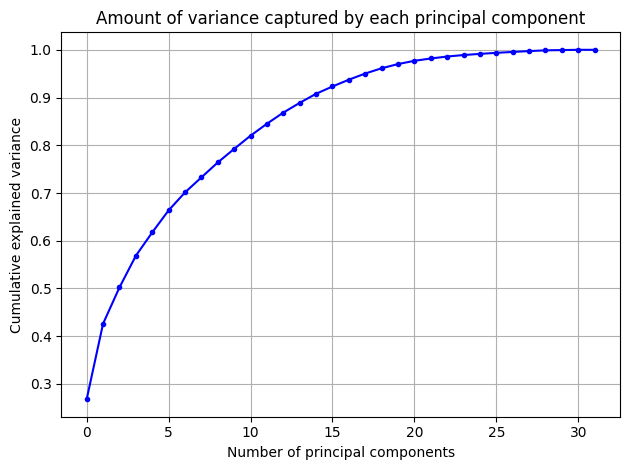

In [ ]:
plt.plot(range(len(cumsum)), cumsum, marker='.', linestyle='-', color='b')
plt.title('Amount of variance captured by each principal component')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.tight_layout()
plt.show()

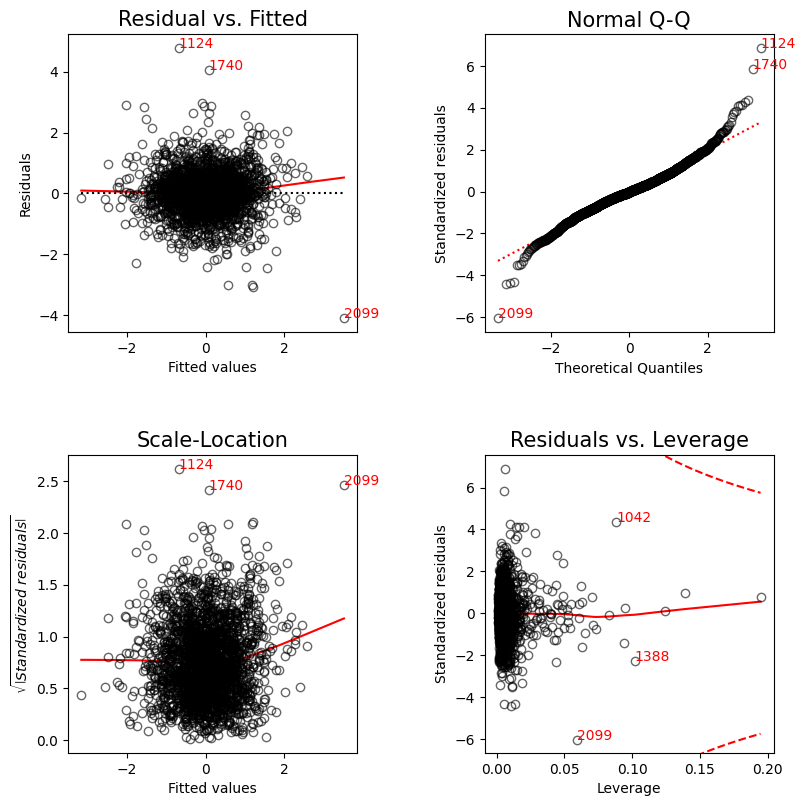

In [ ]:
plt.figure(figsize=(8, 8))
lmdiag.plot(model_pca);

*   PCA giúp giảm chiều dữ liệu, tạo các thành phần chính độc lập tuyến tính với nhau có thể hỗ trợ cho các mô hình tuyến tính.
*   Với mô hình tốt nhất ta huấn luyện được thì dù lượng thông tin giải thích được chỉ giảm từ 53.4% xuống 50.8% (khoảng 2.6%) nhưng số chiều (biến) đã giảm hơn một nửa. Từ đó, làm mô hình được đơn giản hơn và có thể ứng dụng tốt hơn.
*   Như hình trên thì tổng 3 thành phần chính đầu tiên chỉ giữ được khoảng 50% lượng thông tin của bộ dữ liệu cho thấy bộ dữ liệu này không phân tán trải dài mà có thể có dạng hình cầu.
*   Các biến dự đoán gốc có tương quan với nhau khá lớn, dẫn tới rất dễ bị đa cộng tuyến. Ngoài ra, biến mục tiêu cũng tồn tại tương quan phi tuyến với các biến dự đoán gốc.
*   Mô hình tuyến tính không phù hợp với bộ dữ liệu này.
*   PCA còn giải thích được tương quan của các biến với nhau. Cụ thể như 3 thành phần chính đầu tiên đã phân tích ở phần "Tìm hiểu cấu trúc dữ liệu thông qua tương quan với các thành phần chính".
*   PCA có thể hỗ trợ trực quan hóa bộ dữ liệu (dù mất mát thông tin).

  => Do khả năng vừa hỗ trợ chuẩn bị dữ liệu thỏa giả định cho các mô hình Machine Learning tuyến tính; vừa có thể phân tích cấu trúc, tương quan dữ liệu; vừa trực quan hóa được chúng, PCA theo em là một công cụ quan trọng trong các bài toán phân tích và sử dụng số liệu thực tế. Bởi vì đặc điểm chung của những bộ dữ liệu được dùng trong các bài toán thực tế sẽ luôn nhiều chiều, khó đoán và cần phải được khai thác những đặc điểm sâu hơn của chúng. Và phương pháp tính toán nhanh gọn như PCA có thể đáp ứng điều đó rất tốt.